In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import torch

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('/kaggle/input/kaggle-llm-science-exam/train.csv')

In [3]:
df.head()

,id,prompt,A,B,C,D,E,answer
0,0,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D
1,1,Which of the following is an accurate definiti...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,A
2,2,Which of the following statements accurately d...,The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...,A
3,3,What is the significance of regularization in ...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,C
4,4,Which of the following statements accurately d...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,D


In [4]:
df.answer.value_counts()
for i in ['prompt','A','B','C','D','E']:
    df[i+"_len"] = df[i].apply(lambda x: len(x.split()))

<Axes: >

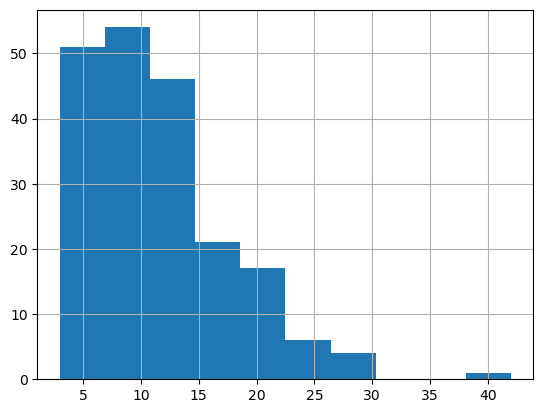

In [5]:
df["prompt_len"].hist()

Avg len of correct answer 28.43
Avg len of incorrect answer 25.43875


<Axes: >

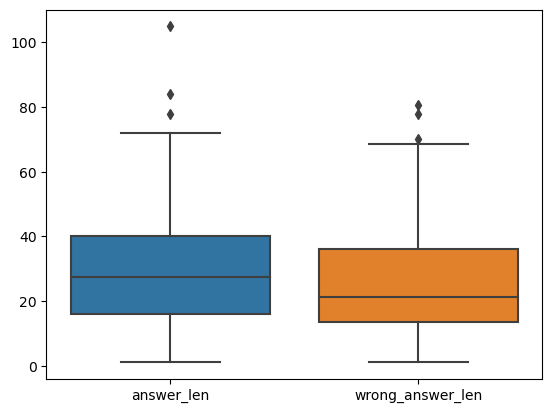

In [6]:
# cheking if length is a factor to consider
df['answer_len'] = np.where(df['answer']=='A',df['A_len'],
                           np.where(df['answer']=='B',df['B_len'],
                           np.where(df['answer']=='C',df['C_len'],
                           np.where(df['answer']=='D',df['D_len'],df['E_len']))))

df['wrong_answer_len'] = np.where(df['answer']=='A',df[['B_len','C_len','D_len','E_len']].mean(1),
                           np.where(df['answer']=='B',df[['A_len','C_len','D_len','E_len']].mean(1),
                           np.where(df['answer']=='C',df[['A_len','B_len','D_len','E_len']].mean(1),
                           np.where(df['answer']=='D',df[['A_len','B_len','C_len','E_len']].mean(1),
                                   df[['A_len','B_len','C_len','D_len']].mean(1)))))

print("Avg len of correct answer",df['answer_len'].mean())
print("Avg len of incorrect answer",df['wrong_answer_len'].mean())
      
sns.boxplot(df[['answer_len','wrong_answer_len']])

# Google Universal Sentence Encoder

In [7]:
import tensorflow as tf
import tensorflow_hub as hub

model_url = "https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/qa/versions/2"

embed = hub.load(model_url)

print("embedding size: ", len(embed([df['prompt'][0]])[0]))

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

embedding size:  512


In [8]:
# cheking if similarity score is different 

def us_encoder(data = df, data_type = 'train'):
    for i in ['prompt','A','B','C','D','E']:
        data[i+'_emb'] = data[i].apply(lambda x : embed([x]))

    lists = [[] for _ in range(5)]

    for j, val in enumerate(['A','B','C','D','E']):
        for index, row in data.iterrows():
            score = tf.keras.losses.cosine_similarity(row['prompt_emb'], row['A_emb']).numpy()[0]
            lists[j].append(score)

        data[val +'_emb_scr'] = lists[j]
        
    if data_type == 'train':
        data['answer_score'] = np.where(data['answer']=='A',data['A_emb_scr'],
                                   np.where(data['answer']=='B',data['B_emb_scr'],
                                   np.where(data['answer']=='C',data['C_emb_scr'],
                                   np.where(data['answer']=='D',data['D_emb_scr'],data['E_emb_scr']))))

        data['wrong_answer_score'] = np.where(data['answer']=='A',data[['B_emb_scr','C_emb_scr','D_emb_scr','E_emb_scr']].mean(1),
                                   np.where(data['answer']=='B',data[['A_emb_scr','B_emb_scr','D_emb_scr','E_emb_scr']].mean(1),
                                   np.where(data['answer']=='C',data[['A_emb_scr','B_emb_scr','C_emb_scr','E_emb_scr']].mean(1),
                                   np.where(data['answer']=='D',data[['A_emb_scr','B_emb_scr','C_emb_scr','E_emb_scr']].mean(1),
                                           data[['A_emb_scr','B_emb_scr','C_emb_scr','D_emb_scr']].mean(1)))))

    return data

In [9]:
df = us_encoder(data = df, data_type = 'train')

Avg similarity score of correct answer -0.48171437
Avg similarity score of incorrect answer -0.48171437


<Axes: >

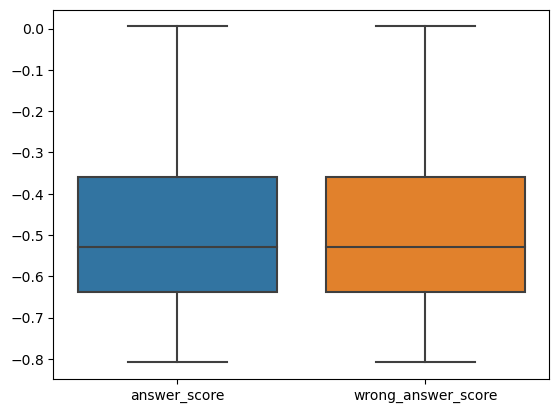

In [10]:
print("Avg similarity score of correct answer",df['answer_score'].mean())
print("Avg similarity score of incorrect answer",df['wrong_answer_score'].mean())
      
sns.boxplot(df[['answer_score','wrong_answer_score']])

In [11]:
# check if this approach is worth exploring

from statsmodels.stats.weightstats import ztest
ztest_Score, p_value = ztest( df['answer_score'], df['wrong_answer_score'] )

# H0 = Means are same

if(p_value <  0.05):
    print("Reject Null Hypothesis")
else:
    print("Fail to Reject NUll Hypothesis")

Fail to Reject NUll Hypothesis


# Bert 

In [12]:
# lets try bert embedding

from transformers import AutoModel, BertTokenizerFast, AutoTokenizer
import torch.nn.functional as F

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

def get_sentence_embedding(sentence):
    tokens = tokenizer(sentence, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**tokens)
    return outputs.last_hidden_state[:, 0, :].squeeze().tolist()


for i in ['prompt','A','B','C','D','E']:
    df[i+"_emb"] = df[i].apply(get_sentence_embedding)


def calculate_cosine_similarity(a, b):
    tensor1 = torch.tensor(a).unsqueeze(0)
    tensor2 = torch.tensor(b).unsqueeze(0)
    return F.cosine_similarity(tensor1, tensor2).item()


df['A_emb_scr'] = df.apply(lambda x : calculate_cosine_similarity(x.prompt_emb, x.A_emb), axis=1)
df['B_emb_scr'] = df.apply(lambda x : calculate_cosine_similarity(x.prompt_emb, x.B_emb), axis=1)
df['C_emb_scr'] = df.apply(lambda x : calculate_cosine_similarity(x.prompt_emb, x.C_emb), axis=1)
df['D_emb_scr'] = df.apply(lambda x : calculate_cosine_similarity(x.prompt_emb, x.D_emb), axis=1)
df['E_emb_scr'] = df.apply(lambda x : calculate_cosine_similarity(x.prompt_emb, x.E_emb), axis=1)

df['answer_score'] = np.where(df['answer']=='A',df['A_emb_scr'],
                           np.where(df['answer']=='B',df['B_emb_scr'],
                           np.where(df['answer']=='C',df['C_emb_scr'],
                           np.where(df['answer']=='D',df['D_emb_scr'],df['E_emb_scr']))))

df['wrong_answer_score'] = np.where(df['answer']=='A',df[['B_emb_scr','C_emb_scr','D_emb_scr','E_emb_scr']].mean(1),
                           np.where(df['answer']=='B',df[['A_emb_scr','B_emb_scr','D_emb_scr','E_emb_scr']].mean(1),
                           np.where(df['answer']=='C',df[['A_emb_scr','B_emb_scr','C_emb_scr','E_emb_scr']].mean(1),
                           np.where(df['answer']=='D',df[['A_emb_scr','B_emb_scr','C_emb_scr','E_emb_scr']].mean(1),
                                   df[['A_emb_scr','B_emb_scr','C_emb_scr','D_emb_scr']].mean(1)))))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Avg similarity score of correct answer 0.7336058604717255
Avg similarity score of incorrect answer 0.7342867667973042


<Axes: >

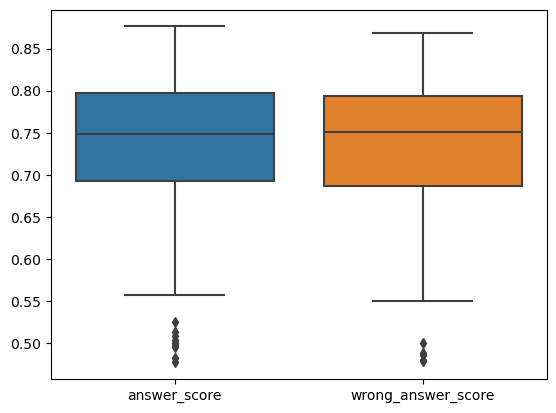

In [13]:
# to see if we are getting better results with Bert embdding

print("Avg similarity score of correct answer",df['answer_score'].mean())
print("Avg similarity score of incorrect answer",df['wrong_answer_score'].mean())
      
sns.boxplot(df[['answer_score','wrong_answer_score']])

# Fine tunning using Bert

In [14]:
train_df = pd.read_csv('/kaggle/input/kaggle-llm-science-exam/train.csv')
train_df.head()

from datasets import Dataset
df = Dataset.from_pandas(train_df)


from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

options = 'ABCDE'
indices = list(range(5))

option_to_index = {option: index for option, index in zip(options, indices)}
index_to_option = {index: option for option, index in zip(options, indices)}

def preprocess(example):
    first_sentence = [example['prompt']] * 5
    second_sentence = []
    for option in options:
        second_sentence.append(example[option])
    tokenized_example = tokenizer(first_sentence, second_sentence, truncation=True)
    tokenized_example['label'] = option_to_index[example['answer']]
    return tokenized_example

tokenized_df = df.map(preprocess, batched=False, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E', 'answer'])


  0%|          | 0/200 [00:00<?, ?ex/s]

In [15]:
from dataclasses import dataclass
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from typing import Optional, Union
import torch

@dataclass
class DataCollatorForMultipleChoice:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    
    def __call__(self, features):
        label_name = "label" if 'label' in features[0].keys() else 'labels'
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]['input_ids'])
        flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features
        ]
        flattened_features = sum(flattened_features, [])
        
        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors='pt',
        )
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        batch['labels'] = torch.tensor(labels, dtype=torch.int64)
        return batch

    
from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer
model = AutoModelForMultipleChoice.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 

In [16]:
model_dir = 'finetuned_bert'
training_args = TrainingArguments(
    output_dir=model_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to='none'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_df,
    eval_dataset=tokenized_df,
    tokenizer=tokenizer,
    data_collator=DataCollatorForMultipleChoice(tokenizer=tokenizer),
)

trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,No log,1.584253
2,No log,1.294621
3,No log,1.080697


TrainOutput(global_step=150, training_loss=1.4817369588216145, metrics={'train_runtime': 1659.4893, 'train_samples_per_second': 0.362, 'train_steps_per_second': 0.09, 'total_flos': 129467976782040.0, 'train_loss': 1.4817369588216145, 'epoch': 3.0})

In [17]:
predictions = trainer.predict(tokenized_df)


def predictions_to_map_output(predictions):
    sorted_answer_indices = np.argsort(-predictions)
    top_answer_indices = sorted_answer_indices[:,:3] # Get the first three answers in each row
    top_answers = np.vectorize(index_to_option.get)(top_answer_indices)
    return np.apply_along_axis(lambda row: ' '.join(row), 1, top_answers)

arr1 = predictions_to_map_output(predictions.predictions)

In [18]:
train_df['prediction'] = arr1
train_df['First'], train_df['Second'], train_df['Third'] = zip(*train_df['prediction'].apply(lambda x: x.split(" ")))

<Axes: xlabel='column', ylabel='accuracy'>

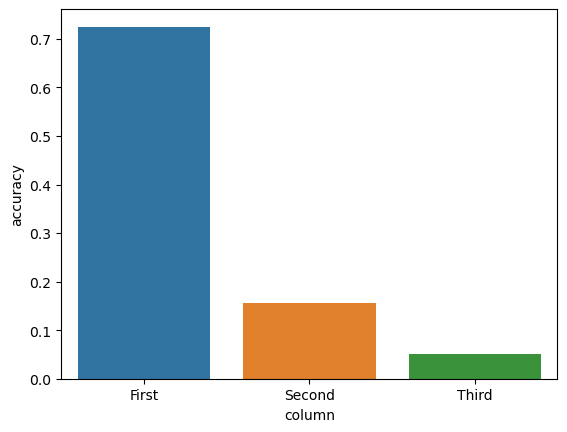

In [19]:
dict1 = {
    'First': sum(np.where(train_df['answer']==train_df['First'],1,0))/200,
    'Second': sum(np.where(train_df['answer']==train_df['Second'],1,0))/200,
    'Third': sum(np.where(train_df['answer']==train_df['Third'],1,0))/200
}

sns.barplot(data=pd.DataFrame(dict1.items(), columns=['column', 'accuracy']), x="column", y="accuracy")

In [20]:
test_df = pd.read_csv('/kaggle/input/kaggle-llm-science-exam/test.csv')

test_df['answer'] = 'A'
test = Dataset.from_pandas(test_df)
tokenized_test = test.map(preprocess, batched=False, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E', 'answer'])

test_pred = trainer.predict(tokenized_test)

submission = test_df[['id']]
submission['prediction'] = predictions_to_map_output(test_pred.predictions)

submission.to_csv('submission.csv', index=False)

  0%|          | 0/200 [00:00<?, ?ex/s]

/tmp/ipykernel_20/1511333680.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['prediction'] = predictions_to_map_output(test_pred.predictions)
